# Reconnaissance des types de notes
**Input du notebook** : 
- Un dataset d'entraînement comportant des images de notes de musiques variées.

**Output du notebook** : 
- Un modèle entraîné qui servira à prédire les notes de futures nouvelles partitions

Pour déterminer le type de note, la propriété des CNN "d’invariance par translation" est gênante. En effet - et contrairement à un chat ou un chien - une note détectée dans un endroit de la photo n’est pas le même objet si on l’observe à un autre endroit ! 

In [1]:
import pandas as pd
import numpy as np ; np.random.seed(123)
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from preprocessing import *
import os
LARG, LONG = 14, 72

On commence par lire les images d'entraînement dans un numpy array : 

In [2]:
train_files = tri_images('Datasets/Train/*.png') + tri_images('Datasets/Train_mirored/*.png')
valid_files = tri_images('Datasets/Valid/*.png')

X_train = np.zeros((1, LARG*LONG))
X_valid = np.zeros((1, LARG*LONG))

for image in train_files:
    image = plt.imread(image)[:, :, 0].reshape(1, LARG*LONG)
    X_train = np.append(X_train, image, axis=0)

for image in valid_files:
    image = plt.imread(image)[:, :, 0].reshape(1, LARG*LONG)
    X_valid = np.append(X_valid, image, axis=0)

X_train = X_train[1:,:]
X_valid = X_valid[1:,:]

y_train = get_label_from_files(train_files, mode="multiclasse")
y_valid = get_label_from_files(valid_files, mode="multiclasse")

X_train.shape, X_valid.shape

((3130, 1008), (636, 1008))

In [3]:
avec_PCA = False
if avec_PCA:
    from sklearn.decomposition import PCA
    n_components = 15
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    df = pd.DataFrame(X_train, columns=['ax'+str(i+1) for i in range(n_components)])
else : 
    df = pd.DataFrame(X_train)
df['file'] = train_files
df['Y'] = y_train

In [12]:
df.drop(['ax15', 'ax14', 'ax12', 'ax13', 'ax11', 'file'], 1).tail(3)

,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,Y
3127,-3.467437,0.829058,-1.125548,-0.627155,-2.878969,-2.474805,-1.281519,0.185696,-0.592408,-0.707167,Do_aigu
3128,-4.503528,-2.019420,-0.204225,0.419248,-0.211800,0.081598,-0.501774,0.173514,-1.168080,-0.980216,0
3129,-3.431899,3.140764,-2.643586,-2.987159,-0.395697,0.461738,-3.094369,-1.066760,-1.301114,-1.609749,Si


In [70]:
df.Y.value_counts()

0                     1846
Si                     230
La                     180
Do_aigu                180
Re_aigu                133
Sol                    133
Mi_aigu                 86
Fa                      86
Mi                      66
Fa_aigu                 66
Re                      41
Sol_aigu                41
Do_aigu_stretched       13
La_stretched            13
La_aigu                  7
Do                       7
Sol_aigu_stretched       1
Re_stretched             1
Name: Y, dtype: int64

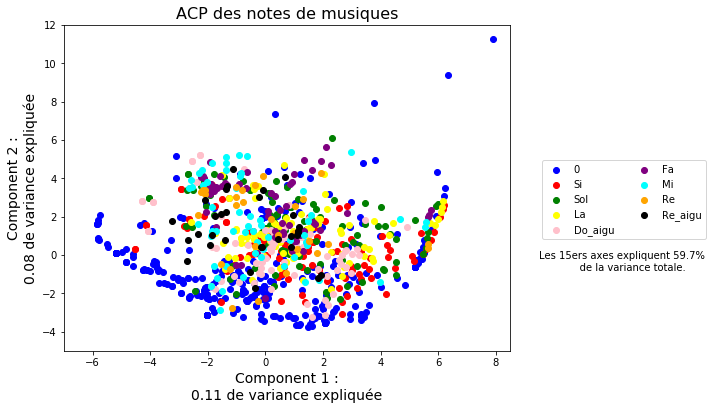

In [155]:
if avec_PCA:
    plt.figure(figsize=(8,6))
    couleurs = ['blue','red','green','yellow','pink', 'purple', 'cyan', 'orange', 'black', 'brown']
    notes = df.Y.value_counts().index[df.Y.value_counts()>30] # min. 50 notes pour représenter la modalité
    for note, coul in zip(notes, couleurs):
        # Sélection aléatoire de points, trop nombreux pour être tous représentés : 
        idx_kept = np.random.choice(df.ax1[df.Y == note].index, 400)
        plt.scatter(df.ax1[df.index.isin(idx_kept)], df.ax2[df.index.isin(idx_kept)], c=coul, label=note)

    plt.title('ACP des notes de musiques', size=16)
    a, b = pca.explained_variance_ratio_[:2]
    plt.xlabel('Component 1 :\n%.2f de variance expliquée'%a, size=14)
    plt.ylabel('Component 2 :\n%.2f de variance expliquée'%b, size=14)
    plt.xlim((-7,8.5)) ; plt.ylim((-5,12))
    plt.legend(ncol=2, bbox_to_anchor=(0.95, 0., 0.5, 0.6))
    plt.text(9.5, -0.8, f"""Les {n_components}ers axes expliquent {sum(pca.explained_variance_ratio_):.1%}
             de la variance totale.""")
    plt.show()

Comme on s'intéresse à prédire **le type** de note contenue dans une image, on pourrait supprimer les images qui n'en contienne pas. Toutefois, si le modèle 1 (CNN binaire) se trompe en disant qu'une image contient une note, le modèle 2 (random forest multiclasse) pourra corriger cette erreur. 

In [25]:
# On vérifie qu'il n'y a pas de nouvelles notes dans l'échantillon de validation : 
assert set(y_valid) - set(df.Y) == set()

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, criterion='entropy')
forest.fit(X_train, y_train)
forest.score(X_valid, y_valid)

0.8789308176100629

In [175]:
# tentative avec un knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
knn.score(X_valid, y_valid)

0.8474842767295597

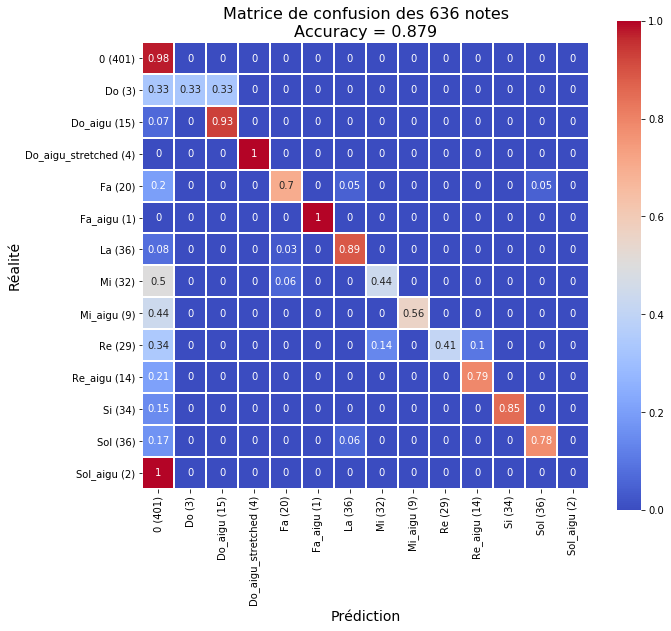

In [62]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, accuracy_score
from seaborn import heatmap
pred_valid = forest.predict(X_valid)

cm = confusion_matrix(y_valid, pred_valid)
cm = (cm / cm.sum(axis=1, keepdims=True)).round(2) # Normalisation par ligne
index = [x + f" ({pd.Series(y_valid).value_counts()[{x}][0]})" for x in forest.classes_ if x in y_valid]
cm = pd.DataFrame(cm, index=index, columns=index)

def plot_heatmap(cm, y_valid, pred_valid):
    plt.figure(figsize=(10,9))
    heatmap(cm, square=True, cmap='coolwarm', annot=True, linewidths=1)
    plt.title(f"""Matrice de confusion des {pred_valid.shape[0]} notes\nAccuracy = {accuracy_score(pred_valid, y_valid):.3f}""", size=16);
    plt.xlabel('Prédiction', fontsize=14) ; plt.ylabel('Réalité', fontsize=14)
plot_heatmap(cm, y_valid, pred_valid)

Le modèle fait du bon travail ! On l'entraîne sur toutes les données avant de l'enregistrer pour faire des prédictions ultérieures :

In [63]:
X = np.concatenate([X_train, X_valid], axis=0)
y = np.concatenate([y_train, y_valid], axis=0)

In [64]:
# Ré-entraînement sur toute la base : 
forest.fit(X, y)

# Enregistrement du modèle : 
joblib.dump(forest, 'Modeles/random_forest.pkl')

['Modeles/random_forest.pkl']